#Imports

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


#Campos

In [ ]:
drop_col    = ['isSearchEngineCrawler','id','businessContext','pathname','experiments','remarks',
               'street','furniture','firstPublicationDate','lastPublicationDate','city',
               'stateAcronym','neighborhood','region_name']
numeric_col = ['condoPrice','homeProtection','bedrooms','area','parkingSpaces',
               'rentalGuarantee_min','rentalGuarantee_max','suites','iptu','bathrooms',
               'floor','totalCost','rentPrice','region_id','lat','lng']
bool_col = ['hasFurniture','acceptsPets','isNearSubway']
categorical_col = ['iptuType','rentalAdministrator','type','availabilityType','ownership']

#Carregamento dos dados principais

In [ ]:
path = '/content/drive/MyDrive/TCC_PUC/Pickle/my_data.pkl'
df = pd.read_pickle(path)
df=df.dropna(subset=['firstPublicationDate','lat','lng'],axis=0)                      #remove linhas sem data de publicação
df[['firstPublicationDate','lastPublicationDate']] = df[['firstPublicationDate','lastPublicationDate']].apply(pd.to_datetime)
df[numeric_col] = df[numeric_col].apply(pd.to_numeric)
df['region_name'] = df.apply(lambda r: r['region_name'].replace('\n', ''), axis=1) # retirar quebra de linhas nos nomes dos bairros
for col in bool_col:
  df[col] = df[col].astype(int)
df=df.dropna(axis=1,how='all')                                            #remove colunas com todos os valores nulos

##Carregamento dados do enriquecimento

In [ ]:
em = pd.read_csv('/content/drive/MyDrive/TCC_PUC/Pickle/estacoes_metro.csv')
em.head(5)

,station,line,company,lng,lat
0,SÉ,AZUL,METRO,-46.633088,-23.551000
1,CORINTHIANS-ITAQUERA,VERMELHA,METRO,-46.471078,-23.542305
2,ARTUR ALVIM,VERMELHA,METRO,-46.484590,-23.540288
3,PATRIARCA,VERMELHA,METRO,-46.501382,-23.531183
4,GUILHERMINA-ESPERANÇA,VERMELHA,METRO,-46.516548,-23.529263
...,...,...,...,...,...
88,CAMPO BELO,LILAS,METRO,-46.682319,-23.618974
89,SÃO MATEUS,PRATA,METRO,-46.476682,-23.612088
90,FAZENDA DA JUTA,PRATA,METRO,-46.487472,-23.611688
91,SAPOPEMBA,PRATA,METRO,-46.501427,-23.614753


##Funções

In [ ]:
def upper_bound(df,col,k=1.5):
  return df[col].quantile(0.75)+k*(df[col].quantile(0.75)-df[col].quantile(0.25))

def drop_outliers(df,cols):
  for col in cols:
    df = df[df[col] < upper_bound(df.copy(),col,k=3)]
  return df

def fill_mode(df,cols):
  for col in cols:
    filler = df[col].mode()[0]
    df[col] = df.apply(lambda r: r[col] if r[col] else filler, axis=1)
  return df

def fill_val(df,col,filler):
  df[col] = df.apply(lambda r: r[col] if not np.isnan(r[col]) else filler, axis=1)
  return df

def geo_distance(lat1,lon1,lat2,lon2):
  # https://en.wikipedia.org/wiki/Haversine_formula
  # https://stackoverflow.com/questions/19412462/
  R = 6373000.0 #raio da terra em metros
  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  return R * 2 * atan2(sqrt(a), sqrt(1 - a))

def geo_matrix(lat,lon):
  mt = em.copy()
  mt['distance'] = mt.apply(lambda r: geo_distance(lat,lon,r['lat'],r['lng']), axis=1)
  return mt.sort_values('distance')

##Processamento IPTU

In [ ]:
# Tem IPTU?
df['has_iptu'] = df.apply(lambda r: r['iptu']!=0, axis=1)
# Cálculo da razão IPTU pelo Custo total
df['iptu_ratio'] = df.apply(lambda r: r['iptu']/r['totalCost'], axis=1)

In [ ]:
# Filtragem e correção dos valoes de IPTU
ub = upper_bound(df.copy(),'iptu_ratio')
iptu_df = df[df['iptu_ratio'] > ub]
df = df[df['iptu_ratio'] < upper_bound(iptu_df.copy(),'iptu_ratio')]
df['totalCost'] = df.apply(lambda r: r['totalCost']-r['iptu']*11/12 if r['iptu_ratio'] > ub else r['totalCost'], axis=1)
df['iptu'] = df.apply(lambda r: r['iptu']/12 if r['iptu_ratio'] > ub else r['iptu'], axis=1)
print(df['iptu_ratio'].mean())
df = df.drop(['iptu_ratio'],axis=1)

0.03004651766345497


##Valores extremos

In [ ]:
#Exclusão dos registros de outliers
display(df.shape)
df = drop_outliers(df.copy(),['iptu','totalCost','area','rentPrice','floor','condoPrice'])
display(df.shape)

(9023, 40)

(6915, 40)

##Registros ausentes

In [ ]:
#Preenchimento com o valor mais frequente
df = fill_mode(df.copy(),['rentalAdministrator','availabilityType'])
#Preenchimento com zero
df = fill_val(df.copy(),'floor',0.0)

##Enriquecimento de dados

In [ ]:
#Cálculo da distância para a estação de metrô
df['metro_dist'] = df.apply(lambda r: geo_matrix(r['lat'],r['lng']).iloc[0]['distance'], axis=1)

#Análise exploratória de dados

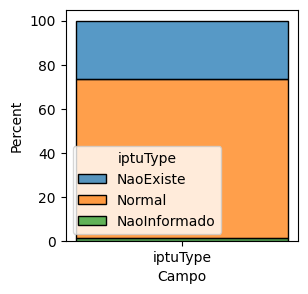

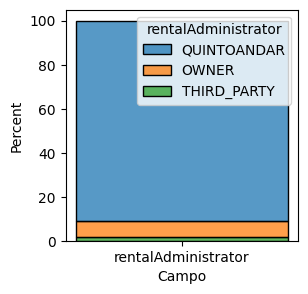

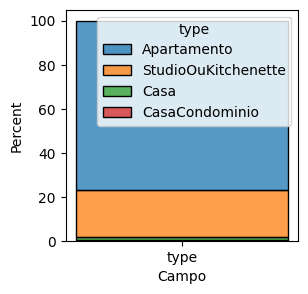

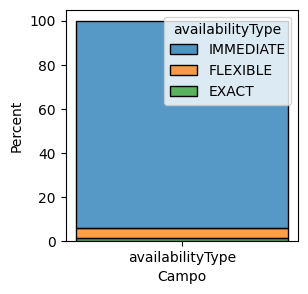

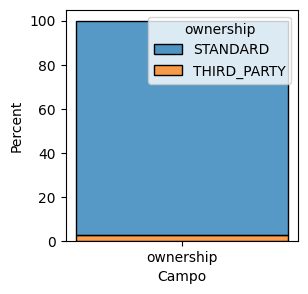

In [ ]:
#Loop para geração de gráficos
for c in categorical_col:
  plt.figure(figsize=(3,3))
  df['Campo'] = c
  a = sns.histplot(data=df,x='Campo',hue=c,stat='percent',multiple='stack')
  plt.show()
df=df.drop(columns=['Campo'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6915 entries, 893937653 to 893590256
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   firstPublicationDate   6915 non-null   datetime64[ns, UTC]
 1   condoPrice             6915 non-null   int64              
 2   iptuType               6915 non-null   object             
 3   homeProtection         6915 non-null   int64              
 4   neighborhood           6915 non-null   object             
 5   rentalAdministrator    6915 non-null   object             
 6   bedrooms               6915 non-null   int64              
 7   id                     6915 non-null   object             
 8   condoType              6915 non-null   object             
 9   region_name            6915 non-null   object             
 10  area                   6915 non-null   int64              
 11  businessContext        6915 non-null   object   

##Feature Engineering

In [ ]:
df['comodos'] = df.apply(lambda r: r['bedrooms']+r['parkingSpaces']+r['suites']+r['bathrooms'], axis=1)

##Redução Dimensionalidade

In [ ]:
bairros = pd.DataFrame(df['region_name'].value_counts()).sort_values(by='region_name',ascending=False)
bairros

,region_name
Santa Cecília,436
Consolação,345
Mooca,312
Bela Vista,297
Centro,287
...,...
Pacaembu,1
Santa Maria,1
Vila Nina,1
Gopoúva,1


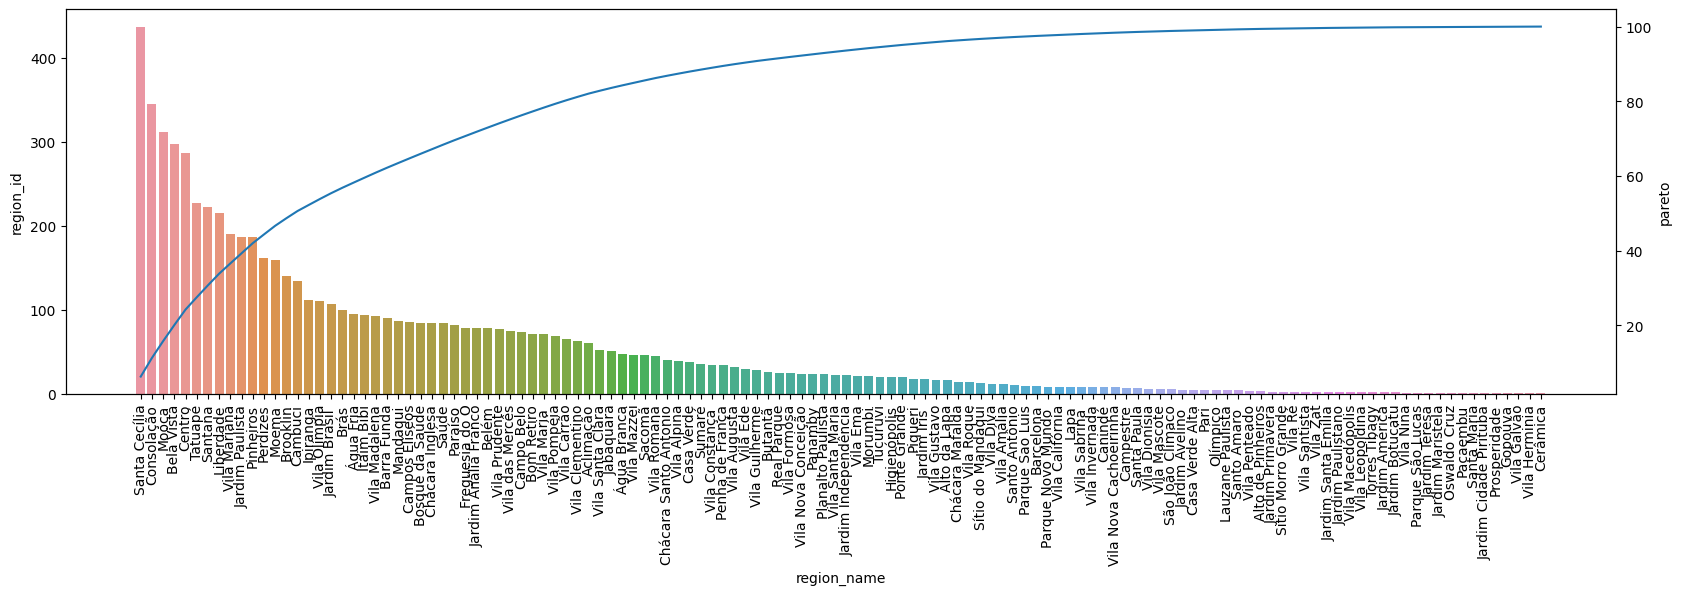

In [ ]:
# Gráfico de pareto
fig, ax1 = plt.subplots(figsize=(20,5)) # initializes figure and plots
ax2 = ax1.twinx() #
lista = df[['region_name','region_id']].groupby(['region_name']).count().sort_values('region_id',ascending=False)
lista['pareto'] =  lista['region_id'].cumsum()/lista['region_id'].sum()*100
g = sns.barplot(data=lista,x=lista.index,y='region_id',ax=ax1)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.lineplot(data=lista,x=lista.index,y='pareto',ax=ax2)
plt.show()

In [ ]:
#Cálculo da linha de corte
lista[lista['pareto']<80].min()

region_id    69.000000
pareto        6.305134
dtype: float64

##Análise multivariada

In [ ]:
sns.scatterplot(data=df,x='lng',y='lat',hue='type',markers=False)

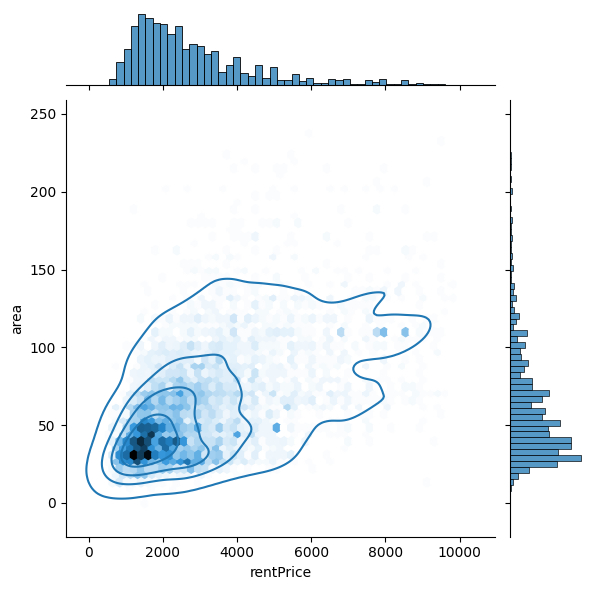

In [ ]:
g = sns.jointplot(data=df, x='rentPrice', y='area',kind="hex")
g.plot_joint(sns.kdeplot,zorder=1, levels=5)

In [ ]:
df.columns

Index(['firstPublicationDate', 'condoPrice', 'iptuType', 'homeProtection',
       'neighborhood', 'rentalAdministrator', 'bedrooms', 'id', 'condoType',
       'region_name', 'area', 'businessContext', 'pathname',
       'isSearchEngineCrawler', 'city', 'type', 'region_id', 'parkingSpaces',
       'hasFurniture', 'rentalGuarantee_min', 'acceptsPets', 'suites', 'iptu',
       'lastPublicationDate', 'bathrooms', 'availabilityType', 'lat',
       'ownership', 'floor', 'stateAcronym', 'experiments', 'totalCost',
       'isNearSubway', 'lng', 'rentPrice', 'rentalGuarantee_max', 'remarks',
       'street', 'furniture', 'has_iptu', 'metro_dist', 'comodos'],
      dtype='object')

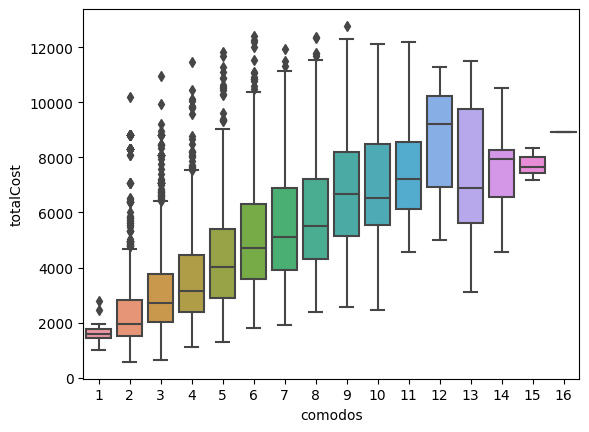

In [ ]:
sns.boxplot(data=df,y="totalCost",x='comodos')
plt.show()

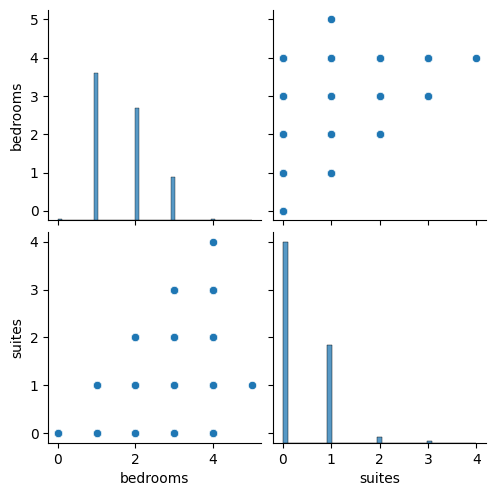

In [ ]:
n = df[['bedrooms','suites']]
sns.pairplot(n)
plt.show()

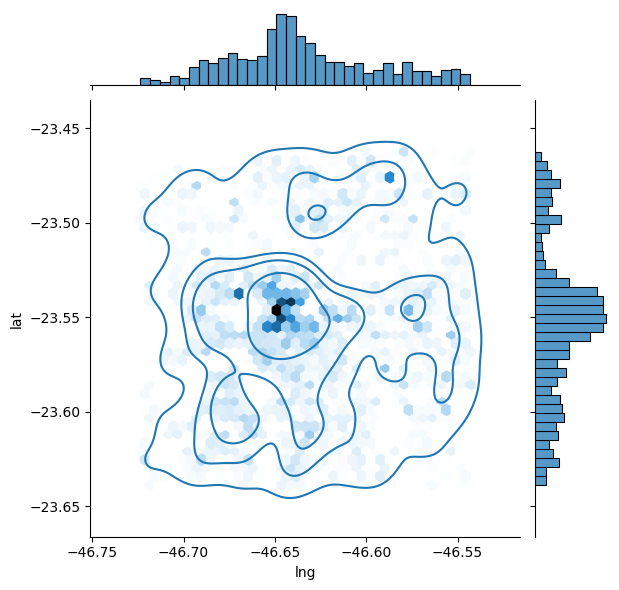

In [ ]:
g = sns.jointplot(data=df, x="lng", y="lat",kind="hex")
g.plot_joint(sns.kdeplot,zorder=1, levels=5)


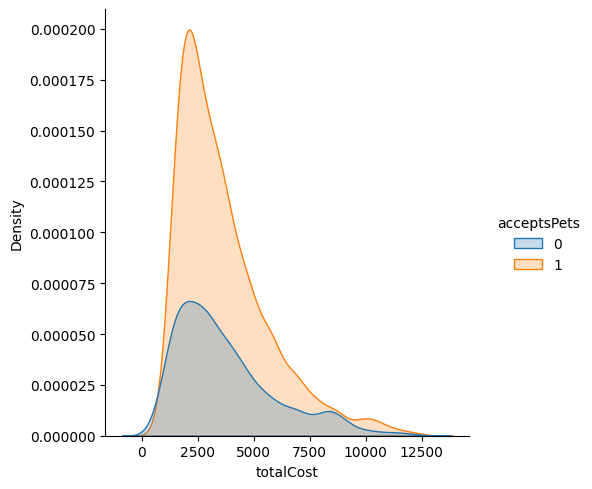

#Análise univariada
##Boxplot

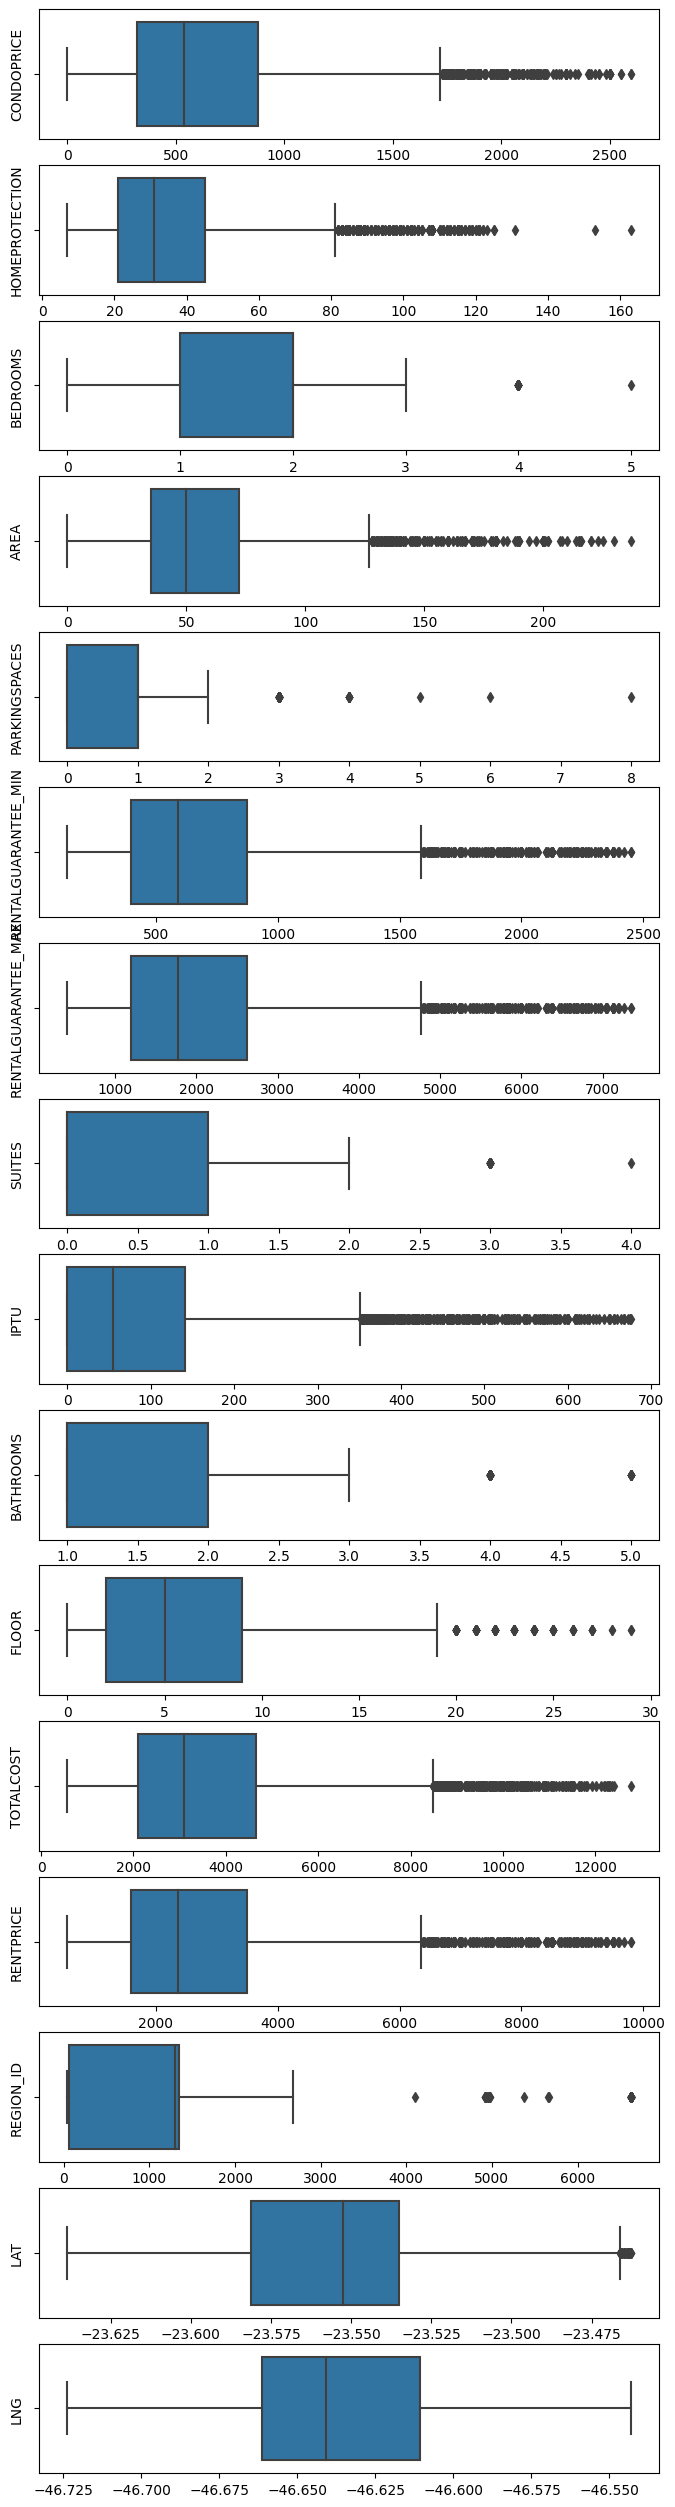

In [ ]:
cols = numeric_col
n = len(cols)
fig, axes = plt.subplots(n,figsize=(8,2*n))
for a in range(n):
  sns.boxplot(data=df,x=cols[a],ax=axes[a]).set(xlabel='',ylabel=cols[a].upper())
fig.show()

##Função densidade de probabilidade

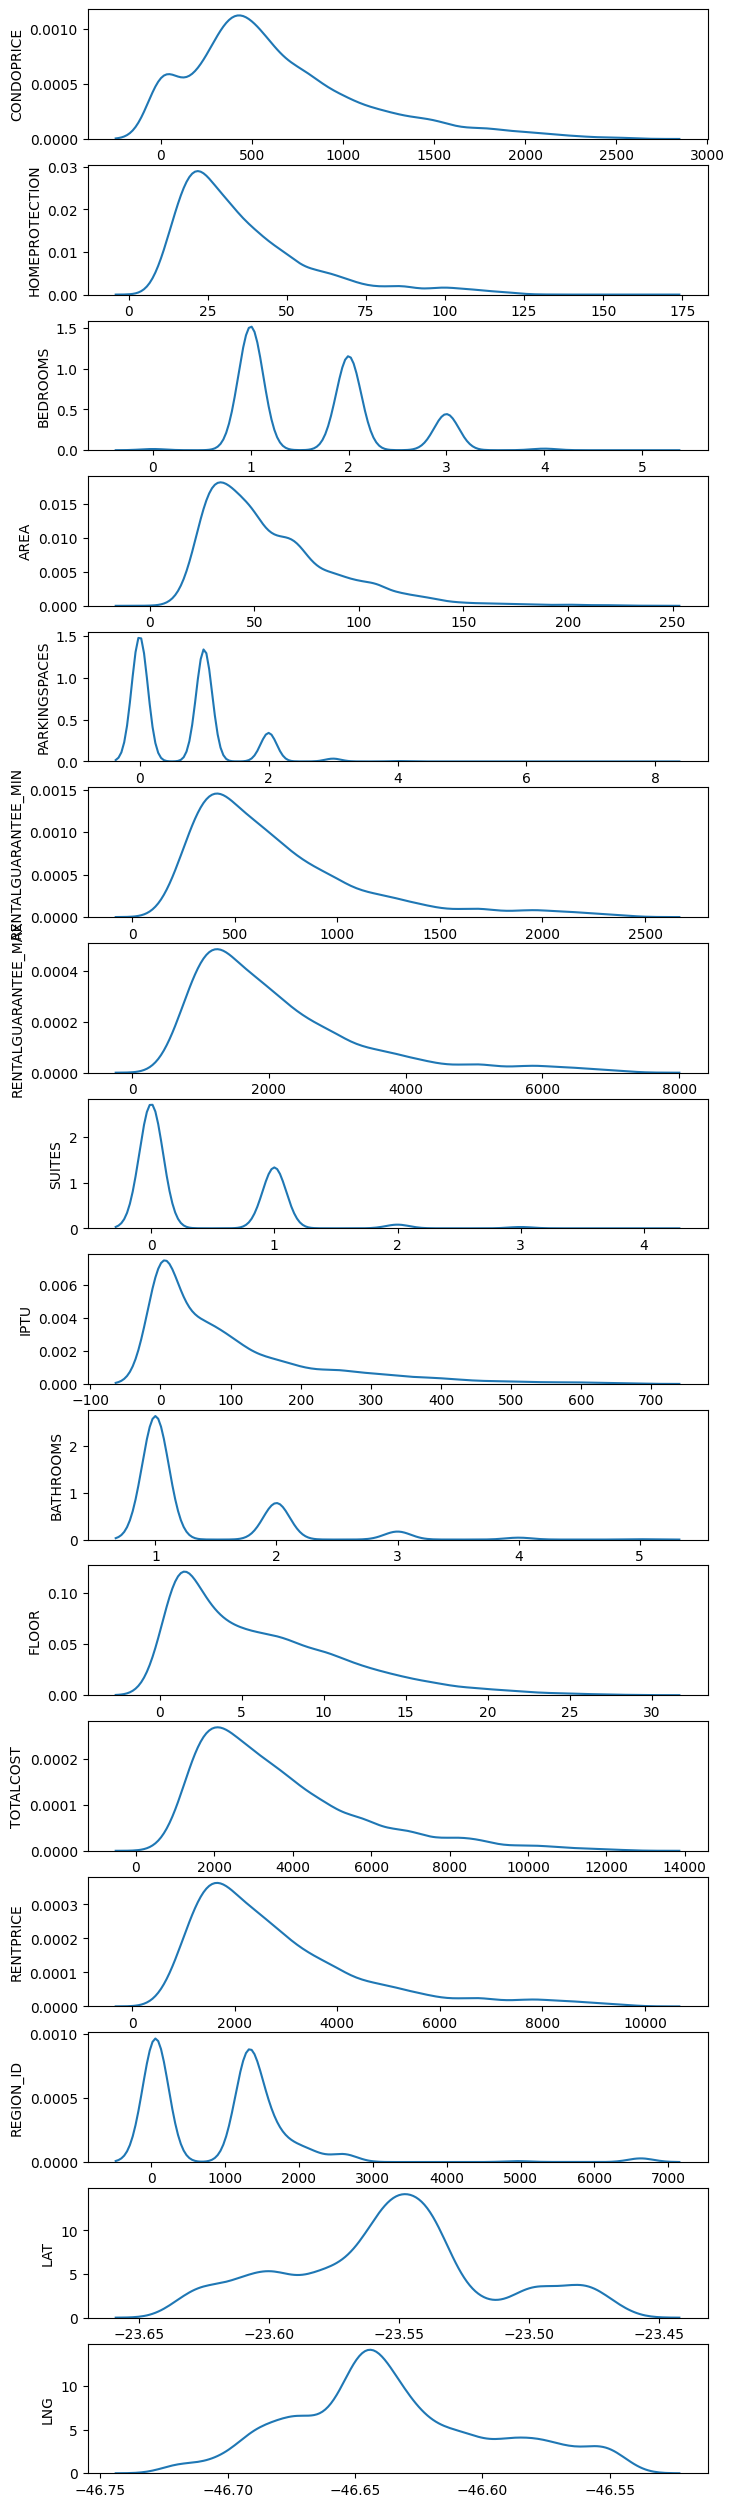

In [ ]:
cols = numeric_col
n = len(cols)
fig, axes = plt.subplots(n,figsize=(8,2*n))
for a in range(n):
  sns.kdeplot(data=df,x=cols[a],ax=axes[a]).set(xlabel='',ylabel=cols[a].upper())
fig.show()

In [ ]:
sns.displot(df, x="totalCost", hue="acceptsPets", kind="kde", fill=True)
plt.show()

In [ ]:
df=df.drop(columns=drop_col) # remover colunas que não serão usadas no modelo

<Axes: xlabel='lng', ylabel='lat'>

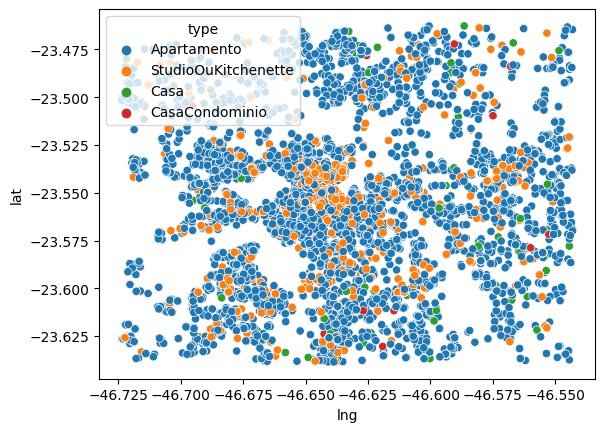

In [27]:
sns.scatterplot(data=df,x='lng',y='lat',hue='type',markers=False)

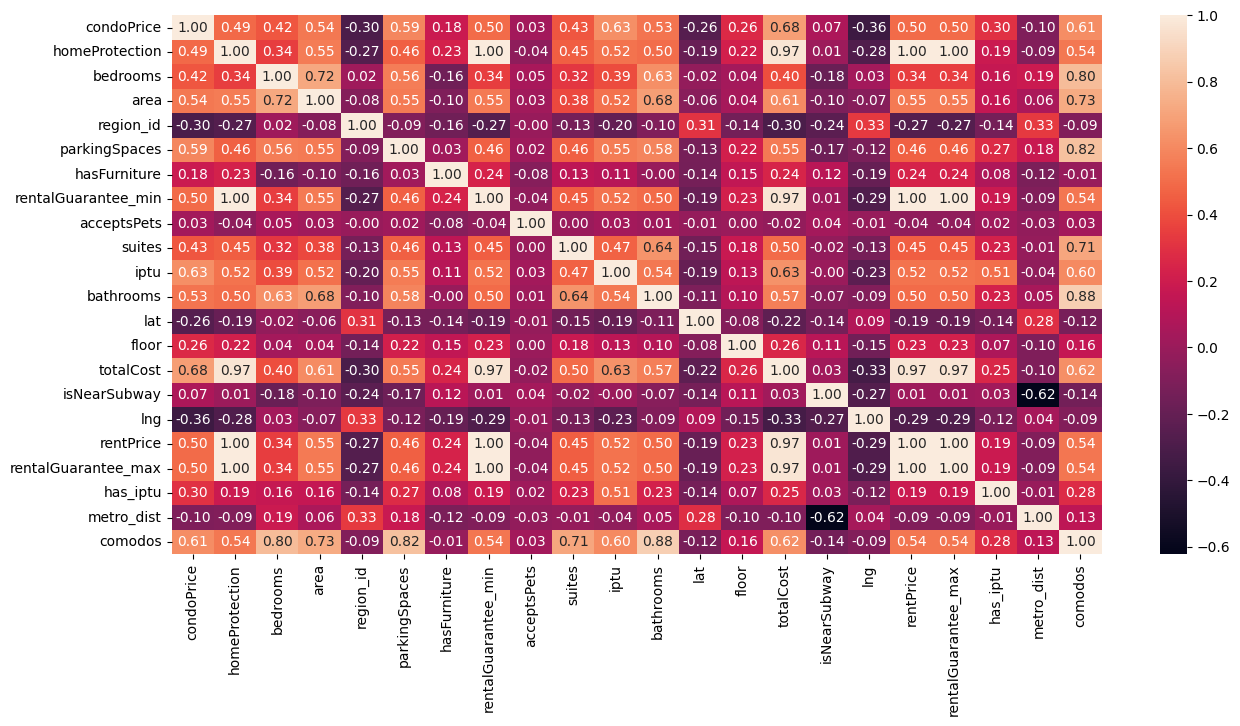

In [28]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,fmt=".2f")
plt.show()

#Modelo

In [29]:
df.describe()

,condoPrice,homeProtection,bedrooms,area,region_id,parkingSpaces,hasFurniture,rentalGuarantee_min,acceptsPets,suites,iptu,bathrooms,lat,floor,totalCost,isNearSubway,lng,rentPrice,rentalGuarantee_max,metro_dist,comodos
count,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000
mean,642.552711,36.515401,1.661894,57.890094,974.795806,0.668691,0.256110,707.365293,0.708604,0.379610,98.088913,1.349241,-23.554284,6.202169,3669.614148,0.652495,-46.635183,2829.461171,2122.095879,1192.453903,4.059436
std,485.648961,21.642135,0.743452,31.712816,1021.144003,0.727171,0.436515,424.662953,0.454438,0.562615,124.567657,0.640633,0.040143,5.225455,2120.022789,0.476212,0.039852,1698.651810,1273.988858,1153.272710,2.156536
min,0.000000,7.000000,0.000000,0.000000,42.000000,0.000000,0.000000,137.500000,0.000000,0.000000,0.000000,1.000000,-23.638514,0.000000,571.000000,0.000000,-46.723600,550.000000,412.500000,12.446945,1.000000
25%,320.000000,21.000000,1.000000,35.000000,61.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000,1.000000,-23.581184,2.000000,2097.000000,0.000000,-46.661356,1600.000000,1200.000000,414.632050,2.000000
50%,536.000000,31.000000,2.000000,50.000000,1297.000000,1.000000,0.000000,590.000000,1.000000,0.000000,55.000000,1.000000,-23.552592,5.000000,3099.000000,1.000000,-46.640759,2360.000000,1770.000000,715.741113,3.000000
75%,880.000000,45.000000,2.000000,72.000000,1343.000000,1.000000,1.000000,875.000000,1.000000,1.000000,140.500000,2.000000,-23.535186,9.000000,4649.500000,1.000000,-46.610622,3500.000000,2625.000000,1630.795033,5.000000
max,2598.000000,163.000000,5.000000,237.000000,6626.000000,8.000000,1.000000,2450.000000,1.000000,4.000000,676.000000,5.000000,-23.462685,29.000000,12774.000000,1.000000,-46.543063,9800.000000,7350.000000,7540.450471,16.000000


In [30]:
pd.DataFrame(df['ownership'].value_counts()).sort_values(by='ownership',ascending=False)

,ownership
STANDARD,6721
THIRD_PARTY,194


In [31]:
df.to_pickle("/content/drive/MyDrive/TCC_PUC/Pickle/processed_data.pkl")

In [32]:
df.head(15)

,condoPrice,iptuType,homeProtection,rentalAdministrator,bedrooms,condoType,area,type,region_id,parkingSpaces,hasFurniture,rentalGuarantee_min,acceptsPets,suites,iptu,bathrooms,availabilityType,lat,ownership,floor,totalCost,isNearSubway,lng,rentPrice,rentalGuarantee_max,has_iptu,metro_dist,comodos
893937653,0,NaoExiste,102,QUINTOANDAR,1,IncluidoNoAluguel,108,Apartamento,1916,0,0,2000.00,0,0,0.000000,1,IMMEDIATE,-23.477206,STANDARD,8.0,8309.000000,0,-46.587454,8000,6000.00,False,1630.795033,2
893797315,396,Normal,14,QUINTOANDAR,1,Normal,40,StudioOuKitchenette,55,0,0,276.25,1,0,46.000000,1,IMMEDIATE,-23.555625,STANDARD,4.0,1589.000000,1,-46.649463,1105,828.75,True,795.216299,2
893780813,320,NaoExiste,24,QUINTOANDAR,1,Normal,56,Apartamento,55,0,0,468.75,1,0,0.000000,1,IMMEDIATE,-23.560318,STANDARD,2.0,2267.000000,1,-46.642715,1875,1406.25,False,446.416825,2
893725632,480,NaoExiste,40,QUINTOANDAR,1,Normal,22,Apartamento,42,0,0,778.75,1,0,0.000000,1,IMMEDIATE,-23.610465,STANDARD,2.0,3715.000000,1,-46.676014,3115,2336.25,False,716.638104,2
893962721,1100,Normal,61,QUINTOANDAR,3,Normal,130,Apartamento,1323,3,0,1200.00,1,1,209.000000,3,IMMEDIATE,-23.617071,STANDARD,7.0,6294.000000,1,-46.568574,4800,3600.00,True,3433.159580,10
893023681,1300,Normal,44,QUINTOANDAR,2,Normal,86,Apartamento,46,3,0,860.25,0,2,209.000000,3,IMMEDIATE,-23.603929,STANDARD,7.0,5083.000000,1,-46.666328,3441,2580.75,True,447.423024,10
893010454,800,Normal,60,QUINTOANDAR,1,Normal,49,Apartamento,72,1,1,1172.50,1,1,192.000000,2,FLEXIBLE,-23.549695,STANDARD,26.0,5863.000000,1,-46.643760,4690,3517.50,True,533.690502,5
893956948,371,Normal,49,QUINTOANDAR,2,Normal,104,Apartamento,72,0,0,950.00,0,0,179.000000,1,IMMEDIATE,-23.554570,STANDARD,2.0,4497.000000,1,-46.654524,3800,2850.00,True,666.161043,3
893946006,1327,Normal,108,QUINTOANDAR,3,Normal,164,Apartamento,1304,3,0,2125.00,1,3,355.000000,3,IMMEDIATE,-23.531340,STANDARD,19.0,10510.000000,0,-46.577619,8500,6375.00,True,1021.248408,12
893499171,1252,Normal,74,QUINTOANDAR,3,Normal,115,Apartamento,61,1,0,1450.00,1,1,186.000000,2,IMMEDIATE,-23.562737,STANDARD,6.0,7462.000000,1,-46.677096,5800,4350.00,True,567.546748,7
